In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Importing Pre-trained Network



In [ ]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False, input_shape=(150, 150, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
base_dir = '/content/drive/MyDrive/cats and dogs'
train_dir = os.path.join(base_dir, 'train_data')
validation_dir = os.path.join(base_dir, 'validation_data')
test_dir = os.path.join(base_dir, 'test_data')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [ ]:
def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
  i=0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
1/1 [==============================] - 0s 23ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 22ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 25ms/step


# Reshaping the extracted features

In [ ]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

# Model Architecture

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])

In [ ]:
history = model.fit(train_features, train_labels,epochs=30,batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 7ms/step - loss: 0.7178 - acc: 0.7550 - val_loss: 0.3844 - val_acc: 0.8150
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3569 - acc: 0.8535 - val_loss: 0.5077 - val_acc: 0.7440
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2740 - acc: 0.8880 - val_loss: 0.2519 - val_acc: 0.8990
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2388 - acc: 0.9065 - val_loss: 0.2496 - val_acc: 0.9090
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2036 - acc: 0.9135 - val_loss: 0.2544 - val_acc: 0.9040
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1838 - acc: 0.9315 - val_loss: 0.3015 - val_acc: 0.8840
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.1771 - acc: 0.9345 - val_loss: 0.2664 - val_acc: 0.8990
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

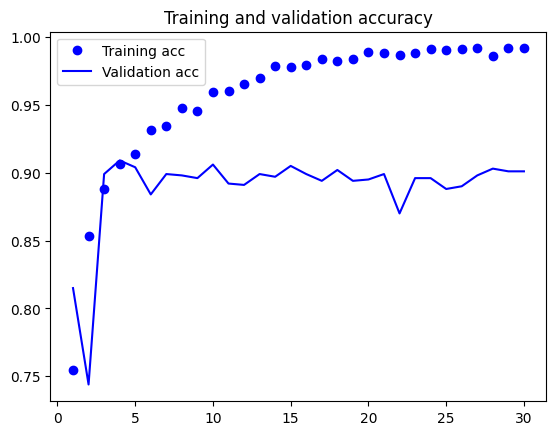

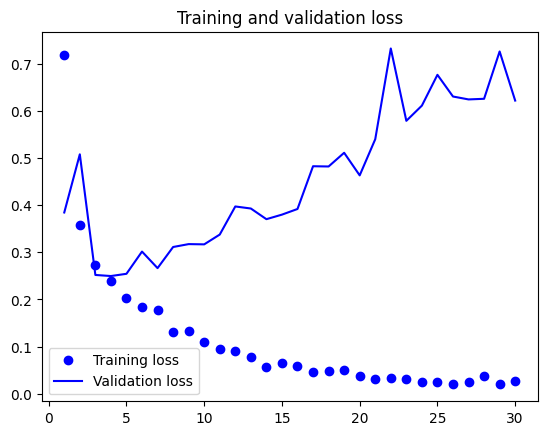

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# FEATURE EXTRACTION WITH DATA AUGMENTATION

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
  validation_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
conv_base.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])

history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/30
100/100 [==============================] - 26s 249ms/step - loss: 0.7998 - acc: 0.6830 - val_loss: 0.3472 - val_acc: 0.8320
Epoch 2/30
100/100 [==============================] - 24s 236ms/step - loss: 0.4529 - acc: 0.7860 - val_loss: 0.2729 - val_acc: 0.8840
Epoch 3/30
100/100 [==============================] - 25s 252ms/step - loss: 0.4128 - acc: 0.8070 - val_loss: 0.2717 - val_acc: 0.8900
Epoch 4/30
100/100 [==============================] - 24s 240ms/step - loss: 0.3985 - acc: 0.8075 - val_loss: 0.3624 - val_acc: 0.8350
Epoch 5/30
100/100 [==============================] - 25s 253ms/step - loss: 0.3748 - acc: 0.8295 - val_loss: 0.2828 - val_acc: 0.8760
Epoch 6/30
100/100 [==============================] - 26s 255ms/step - loss: 0.3637 - acc: 0.8390 - val_loss: 0.3324 - val_acc: 0.8580
Epoch 7/30
100/100 [==============================] - 24s 237ms/step - loss: 0.3599 - acc: 0.8325 - val_loss: 0.2568 - val_acc: 0.8870
Epoch 8/30
100/100 [==============================] - 2

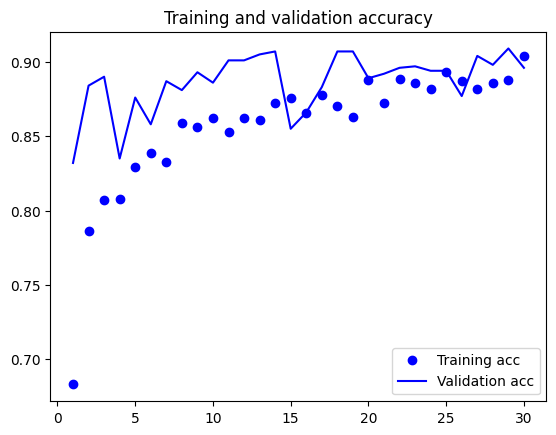

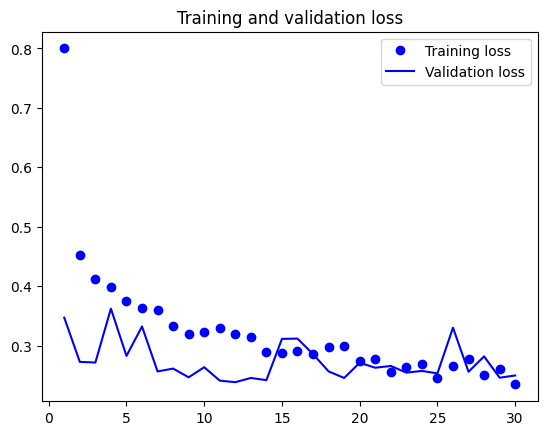

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Fine Tuning network

In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
from keras import optimizers
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-5),metrics=['acc'])

In [ ]:
history = model.fit(train_generator,steps_per_epoch=100,epochs=100,
  validation_data=validation_generator,
  validation_steps=50)

Epoch 1/100
100/100 [==============================] - 1009s 10s/step - loss: 2.4206 - acc: 0.4950 - val_loss: 0.6931 - val_acc: 0.5010
Epoch 2/100
100/100 [==============================] - 22s 215ms/step - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5010
Epoch 3/100
100/100 [==============================] - 23s 233ms/step - loss: 0.7363 - acc: 0.5130 - val_loss: 0.6904 - val_acc: 0.5130
Epoch 4/100
100/100 [==============================] - 23s 228ms/step - loss: 0.7035 - acc: 0.5380 - val_loss: 0.6918 - val_acc: 0.5420
Epoch 5/100
100/100 [==============================] - 24s 242ms/step - loss: 0.6516 - acc: 0.6265 - val_loss: 0.3514 - val_acc: 0.8590
Epoch 6/100
100/100 [==============================] - 23s 234ms/step - loss: 0.4897 - acc: 0.7715 - val_loss: 0.2673 - val_acc: 0.8950
Epoch 7/100
100/100 [==============================] - 24s 239ms/step - loss: 0.4117 - acc: 0.8205 - val_loss: 0.3738 - val_acc: 0.7990
Epoch 8/100
100/100 [===========================

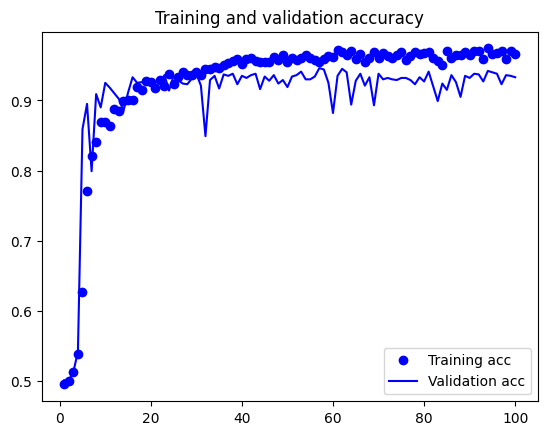

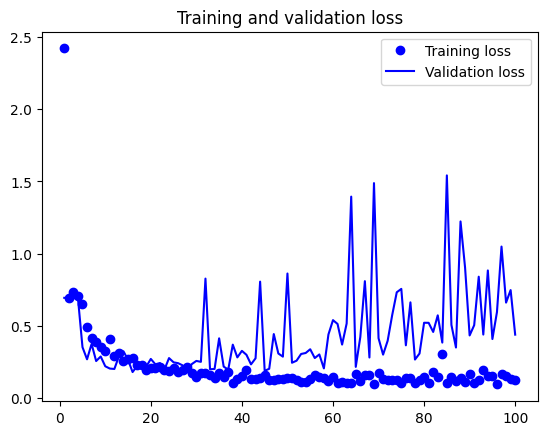

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()